In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from mycolorpy import colorlist as mcp
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from matplotlib import colors



In [2]:
%run Fraunhofer.py

In [3]:
Number_of_Errors  = 100.
Amplitude_of_Errors = 10.

def ErrMask(N,pix_size,Number_of_Errors,Amplitude_of_Errors,amp,sigma,trun_radius):
    
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    
    def point_source(N,pix_size,Number_of_Errors,Amplitude_of_Errors):
        PSMap = np.zeros([int(N),int(N)])
        i = 0.
        while (i < Number_of_Errors):
            pix_x = int(N*np.random.rand())
            pix_y = int(N*np.random.rand()) 
            PSMap[pix_x,pix_y] += np.random.uniform(low=0.0,high=Amplitude_of_Errors)
            i = i + 1
        return(PSMap)
    
    def gaussian_function(N,pix_size,amp,sigma):
        gaussian = amp * np.exp(-(X**2. + Y**2.) / (2*sigma**2))
        return(gaussian)
    
    errmap = point_source(N,pix_size,Number_of_Errors,Amplitude_of_Errors)
    gaussian = gaussian_function(N,pix_size,amp,sigma)
    #convolve
    FT_g = np.fft.fft2(np.fft.fftshift(gaussian))
    FT_err = np.fft.fft2(np.fft.fftshift(errmap))
    ErrMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_g*FT_err)))
    #truncate a circular aperture
    R = np.sqrt((X)**2 + (Y)**2)
    cut_ap = np.where(R<trun_radius,1,0) 
    ErrMap = ErrMap*cut_ap
    
    return(ErrMap,errmap.max())


9.975115825614099 13.762350101455922


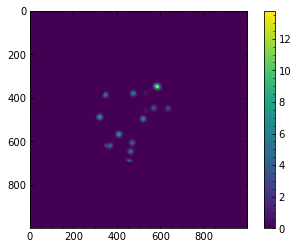

In [5]:
# gaussian: fwhm = sqrt(2) * sigma * sqrt(ln(2))
# ~ 10 cm fwhm --> sigma~0.08
Errormap = ErrMask(1000,0.01,Number_of_Errors,Amplitude_of_Errors,1,0.08,2) 

plt.imshow(Errormap[0])
plt.colorbar()
#plt.xlim(400,600)
#plt.ylim(400,600)
print(Errormap[1],Errormap[0].max())

In [6]:
#randomly generate a position at xi, yi; 
#given sigma, generate a gaussian function that shifts to (xi, yi)

def ErrMask_(N,pix_size,n_error,A,sigma,trun_radius=100):
    #ones = np.ones(N)
    #inds  = (np.arange(N)+.5 - N/2.) * pix_size
    #X = np.outer(ones,inds)
    #Y = np.transpose(X)
    x = np.linspace(0,N*pix_size,N)
    (X,Y) = np.meshgrid(x,x)
    
    def g(x,y,A,sigma, xi, yi):
        gaussian = A * np.exp(-((x-xi)**2. + (y-yi)**2.) / (2*sigma**2))
        return(gaussian)
    
    emap = np.zeros([N,N])
    for i in np.arange(n_error):
        xi = N*pix_size*np.random.rand()
        yi = N*pix_size*np.random.rand()
        amp = A*np.random.rand()
        sig = sigma * np.random.rand()
        gaussiani = g(X,Y,amp,sig,xi,yi)
        emap+=gaussiani
        
    R = np.sqrt((X-(N*pix_size/2))**2 + (Y-(N*pix_size/2))**2)
    cut_ap = np.where(R<trun_radius,1,0) 
    emap = emap*cut_ap
    
    return(emap,X)


def Screen_ErrMask(screen,n_error,A,sigma,trun_radius=2):
    #ones = np.ones(N)
    #inds  = (np.arange(N)+.5 - N/2.) * pix_size
    #X = np.outer(ones,inds)
    #Y = np.transpose(X)
    #x = np.linspace(0,N*pix_size,N)
    #(X,Y) = np.meshgrid(x,x)
    X = screen['X']
    Y = screen['Y']
    N = screen['N']
    
    def g(x,y,A,sigma, xi, yi):
        gaussian = A * np.exp(-((x-xi)**2. + (y-yi)**2.) / (2*sigma**2))
        return(gaussian)
    
    screen['emap'] = np.zeros([N,N])
    for i in np.arange(n_error):
        xi = screen['D']*np.random.rand()
        yi = screen['D']*np.random.rand()
        amp = A*np.random.rand()
        sig = sigma * np.random.rand()
        gaussiani = g(X,Y,amp,sig,xi,yi)
        screen['emap']+=gaussiani
        
    R = np.sqrt((X-(screen['D']/2))**2 + (Y-(screen['D']/2))**2)
    cut_ap = np.where(R<trun_radius,1,0) 
    screen['emap'] = screen['emap']*cut_ap
    
    screen['E'] = screen['E'] + screen['emap']

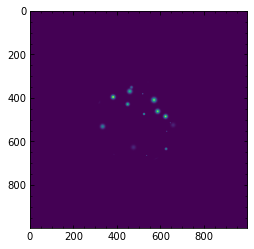

In [37]:
emap = ErrMask_(1000,0.01,100,1,0.08,2)
plt.imshow(emap[0])

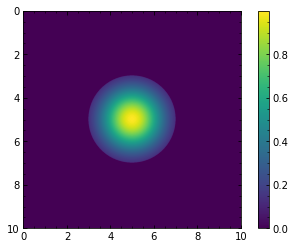

In [8]:
screen = {}
screen['N'] = 1000
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
#c2 = (center[0]-0.2, center[1]-0.1)
#CircleAtten(screen,c2,0.1,1.3)
E_emap = screen['E'] + emap[0]
ScreenFFT(screen)
plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()

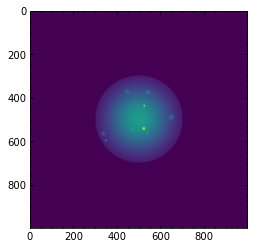

In [31]:
screen1 = {}
screen1['N'] = 1000
screen1['D'] = 10
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, 1.0)
InCircle(screen1, center, 2.0)
#c2 = (center[0]-0.2, center[1]-0.1)
#CircleAtten(screen1,c2,0.1,1.3)
Screen_ErrMask(screen1,100, 1, 0.08, 2)
ScreenFFT(screen1)
plt.imshow(screen1['E'])

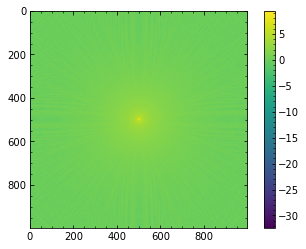

In [10]:
plt.imshow(np.log10(screen['I']))
plt.colorbar()
# plt.xlim(300,700)
# plt.ylim(300,700)

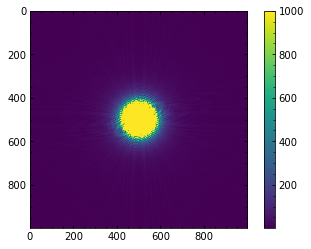

In [36]:
#plt.imshow(np.log10(screen1['I']))
plt.imshow(screen1['I'],vmax=1e3)
plt.colorbar()

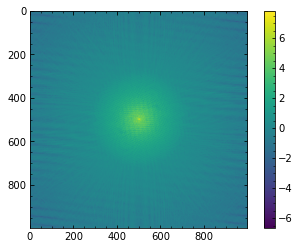

In [33]:
plt.imshow(np.log10(np.abs(screen1['I']-screen['I'])))
plt.colorbar()

In [13]:
screen['FFT_E'] = np.fft.fftshift(np.fft.fft2(screen['E']))
screen['I'] = np.abs(screen['FFT_E'])**2

(400.0, 600.0)

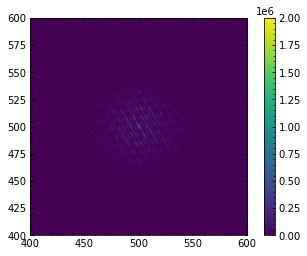

In [14]:
test = np.fft.fftshift(np.fft.fft2(screen1['emap']))
plt.imshow(np.abs(test)**2, vmax=2e6)
plt.colorbar()
plt.xlim(400,600)
plt.ylim(400,600)

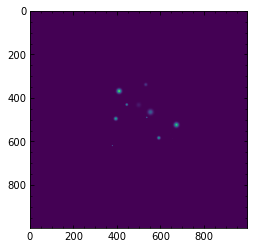

In [15]:
plt.imshow(screen1['emap'])

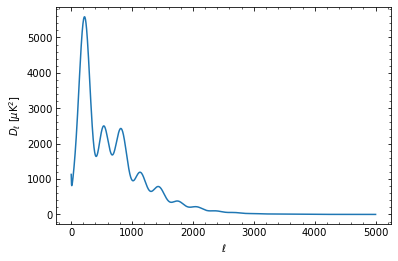

In [16]:
(ell, DlTT) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/CAMB_fiducial_cosmo_scalCls.dat.txt',usecols=(0, 1), unpack=True)
plt.plot(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()
## variables to set up the size of the map
#N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
N = 1000
pix_size  = 0.5 # size of a pixel in arcminutes. field of view in arcmin

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees
radius=0.023 # l~1000

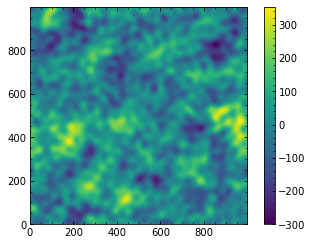

In [17]:
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.

    # make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
Y = np.transpose(X)
    # radial component R
R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
       
    
    # now make a realization of the CMB with the given power spectrum in real space
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    

cut_ap = np.where(R<radius,1,0) 
FT_2d=FT_2d*cut_ap

    # move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
CMB_T = np.real(CMB_T)


test_map = np.fft.ifft2(np.fft.fftshift(FT_2d+screen1['emap'])) 
test_map = test_map/(pix_size /60.* np.pi/180.)
test_map = np.real(test_map)

plt.imshow(CMB_T, interpolation='bilinear', origin='lower')
plt.colorbar()


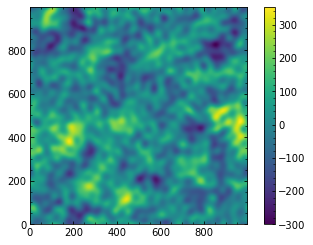

In [18]:
plt.imshow(test_map,interpolation='bilinear', origin='lower')
plt.colorbar()


<ipython-input-19-5391e1c36546>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(test_map-CMB_T))


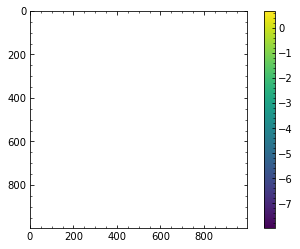

In [19]:
plt.imshow(np.log10(test_map-CMB_T))
plt.colorbar()

(400.0, 600.0)

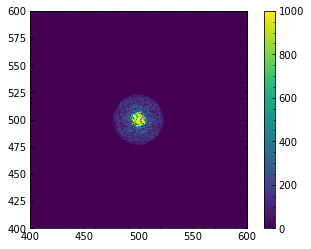

In [20]:
plt.imshow(np.abs(FT_2d),vmax=1000)
plt.colorbar()
plt.xlim(400,600)
plt.ylim(400,600)

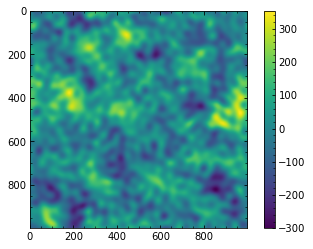

In [21]:
test = FT_2d+screen1['emap']

test_map = np.fft.ifft2(np.fft.fftshift(test)) 
test_map = test_map/(pix_size /60.* np.pi/180.)
test_map = np.real(test_map)

plt.imshow(test_map)
plt.colorbar()

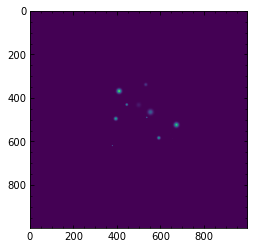

In [22]:
plt.imshow(screen1['emap'])

In [24]:
#randomly generate a position at xi, yi; 
#given sigma, generate a gaussian function that shifts to (xi, yi)
# gaussian: width = 2fwhm = 2 * 2 * sqrt(2) * sigma * sqrt(ln(2))
# ~ 10 cm fwhm --> sigma~0.08

def ErrMask_edge(N,pix_size,n_error,A,sigma,trun_radius=100):
    #ones = np.ones(N)
    #inds  = (np.arange(N)+.5 - N/2.) * pix_size
    #X = np.outer(ones,inds)
    #Y = np.transpose(X)
    x = np.linspace(0,N*pix_size,N)
    (X,Y) = np.meshgrid(x,x)
    x_center,y_center = N*pix_size/2, N*pix_size/2
    
    def g(x,y,A,sigma, xi, yi):
        gaussian = A * np.exp(-((x-xi)**2. + (y-yi)**2.) / (2*sigma**2))
        return(gaussian)
    
    emap = np.zeros([N,N])
    for i in np.arange(n_error):
        xi = N*pix_size*np.random.rand()
        yi = N*pix_size*np.random.rand()
        amp = A*np.random.rand()
        sig = sigma * np.random.rand()
        width = 4*np.sqrt(2)*sig*np.sqrt(np.log(2))
        d = trun_radius - np.sqrt( (xi-x_center)**2 + (yi-y_center)**2 )
        if d>=width:
            gaussiani = g(X,Y,amp,sig,xi,yi)
            emap+=gaussiani
        
    R = np.sqrt((X-(N*pix_size/2))**2 + (Y-(N*pix_size/2))**2)
    cut_ap = np.where(R<trun_radius,1,0) 
    emap = emap*cut_ap
    
    return(emap,X)



9.994623320435117 12.772082972310608


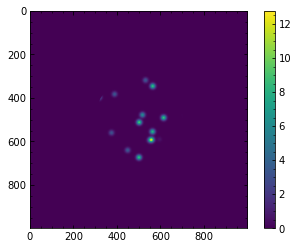

In [24]:
# gaussian: fwhm = sqrt(2) * sigma * sqrt(ln(2))
# ~ 10 cm fwhm --> sigma~0.08
Errormap = ErrMask(1000,0.01,Number_of_Errors,Amplitude_of_Errors,1,0.08,2) 

plt.imshow(Errormap[0])
plt.colorbar()
#plt.xlim(400,600)
#plt.ylim(400,600)
print(Errormap[1],Errormap[0].max())

# 11/14

In [4]:

def filter_annulus(screen, A, k_in, k_out): #  4. consider normalization after fft & ifft 6. only consider real(WN)? 6. what k? 
    """
    k_in, k_out: filter radius in the fourier space
    A = amplitude of error mask"""
    N = screen['N']
    k = screen['kap'] # radius in k space
    
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    screen['E'] = (1 + A*WN_fil) * screen['E']
    return(WN_FT_fil) #return amplitude
    

def filter_annulus_phase(screen, B, k_in, k_out):
    N = screen['N']
    k = screen['kap']
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    E_complex = screen['E']*np.exp(1j*B*WN_fil) 
    #screen['E'] = np.sqrt(np.real(E_complex**2) + np.imag(E_complex)**2)
    screen['E'] = E_complex
    #print(np.imag(E_complex)[500])
    return(B*WN_fil) 
    

def filter_WN(screen, A, k_in, k_out):
    """
    k_in, k_out: filter radius in the fourier space
    A = amplitude of error mask"""
    N = screen['N']
    k = screen['kap'] # radius in k space
    
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil))) # filtered WN in real space
    return(WN_fil)
    
def rms(error_map):
    return np.sqrt(np.mean(error_map**2))

In [5]:
lam = 0.002 #mm wavelength
thetamaxdeg = 5.0
thetamax = 3*np.pi/180. # 3 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,512) 

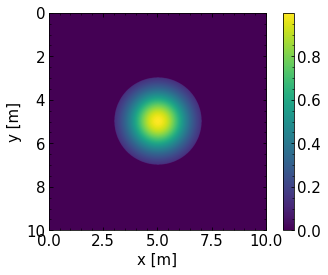

In [6]:
screen = {}
screen['N'] = 1024
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
ScreenFFT(screen)
II = Project_I_on_thetagrid(theta_vec,screen,lam) 

plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.show()


In [10]:
print(screen['kap'][0].max()) # max k of our screen
print(2*np.pi/lam * np.sin(np.deg2rad(3))) # three degrees to max k of our interpolation

72.40773439350248
164.4182556514292


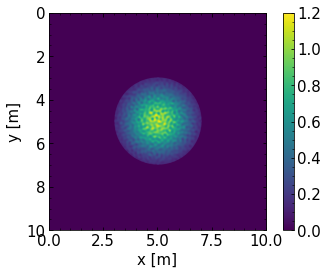

In [11]:
screen1 = {}
screen1['N'] = 1024
screen1['D'] = 10
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, 1.0)
emap = filter_annulus(screen1, 1.0, 3, 6) # 10 - 12 for degree scale errors 
InCircle(screen1, center, 2.0)
ScreenFFT(screen1)
II1 = Project_I_on_thetagrid(theta_vec,screen1,lam) 
#plt.imshow(emap,interpolation=None)#extent=(0,screen1['D'],screen1['D'],0))
#plt.colorbar()
#plt.xlim(900,1100)
#plt.ylim(900,1100)

plt.show()
plt.imshow(np.real(screen1['E']),extent=(0,screen1['D'],screen1['D'],0))
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
# plt.xlim(3,7)
# plt.ylim(3,7)
plt.show()
#plt.imshow(screen1['E'],extent=(0,screen1['D'],screen1['D'],0))
#plt.colorbar()
#print(rms(emap))
#print(emap.max())


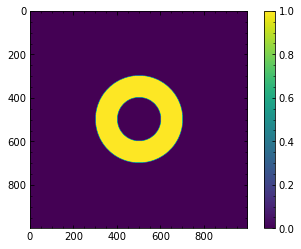

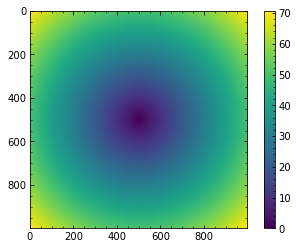

In [57]:
k=screen1['kap']
cut1 = np.where(k<10, 0, 1)
cut2 = np.where(k>20, 0, 1)
plt.imshow(cut1*cut2)
plt.colorbar()
plt.show()
plt.imshow(k)
plt.colorbar()

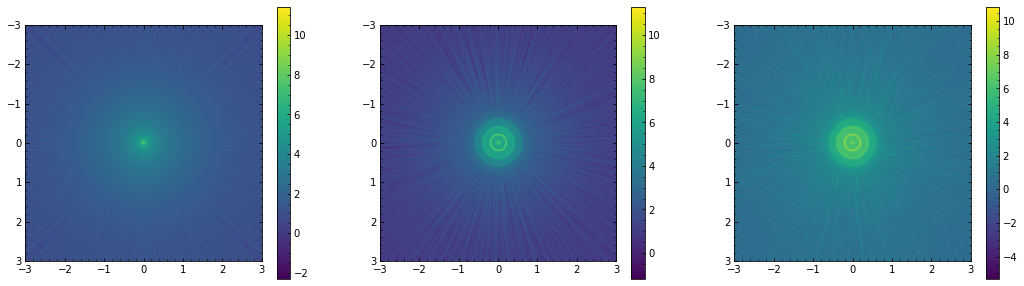

In [23]:
plt.rcParams['figure.figsize'] = [18, 5]
plt.subplot(1,3,1)
plt.imshow(np.log10(II), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(II1), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(II-II1)), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()



#plt.xlim(-1,1)
#plt.ylim(-1,1)
#print(screen['I'].min())

Text(0, 0.5, 'log(I difference)')

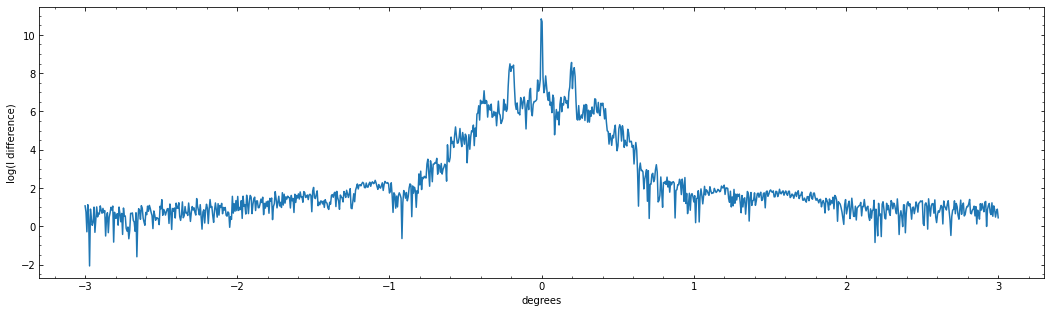

In [35]:
plt.plot(theta_vec*180/np.pi, np.log10(np.abs(II-II1)[512]))
plt.xlabel('degrees')
plt.ylabel('log(I difference)')

160.0


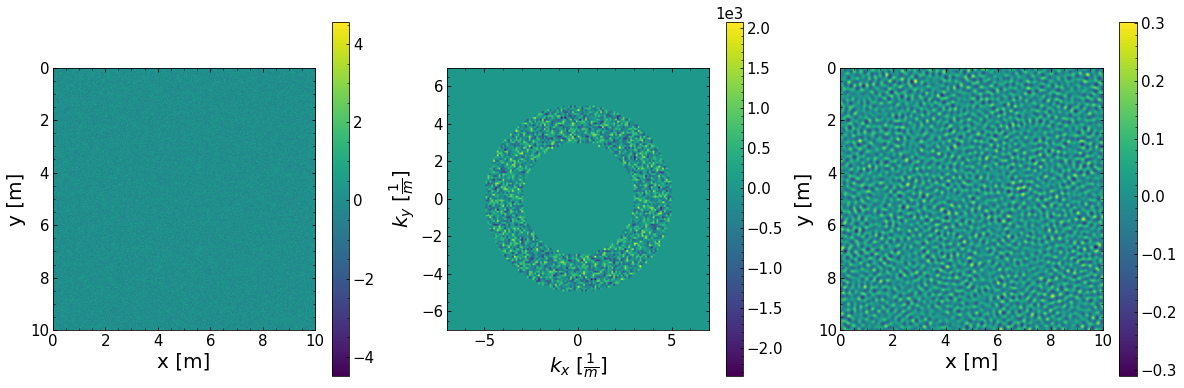

In [26]:
N = screen['N']
k = screen['kap'] # radius in k space
print(16/screen['dk']) #k~16
# white noise
WN = np.random.normal(0,1,(N,N))
WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
#filter
cut1 = np.where(k<3, 0, 1)
cut2 = np.where(k>5, 0, 1)
WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
WN_fil = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil))) # filtered WN in real space
fig = plt.figure(figsize=(20,6.5))
plt.subplot(1,3,1)
plt.imshow(WN,cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('white noise in real space')
plt.xlabel('x [m]', fontsize=20)
plt.ylabel('y [m]', fontsize=20)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.real(WN_FT_fil), cmap='viridis', extent=(screen['kx'].min(),screen['kx'].max(),screen['kx'].max(),screen['kx'].min()))
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
#plt.title('filtered WN in k space')
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.xlabel(r'$k_x$ [$\frac{1}{m}$]', fontsize=20)
plt.ylabel(r'$k_y$ [$\frac{1}{m}$]', fontsize=20)
#plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.real(WN_fil),cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('filtered WN in real space')
plt.xlabel('x [m]', fontsize=20)
plt.ylabel('y [m]', fontsize=20)
plt.colorbar()
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/ErrMap_h.png', bbox_inches='tight', dpi=600)
#screen['E'] = np.real((1 + A*WN_fil) * screen['E'])

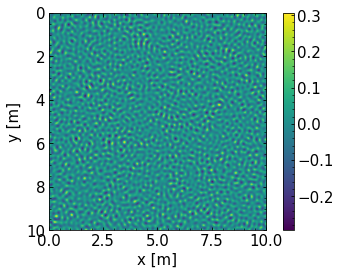

In [27]:
plt.imshow(np.real(WN_fil),cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('filtered WN in real space')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()

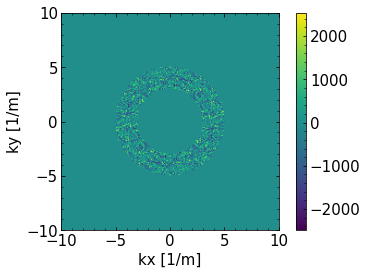

In [10]:
plt.imshow(np.real(WN_FT_fil), cmap='viridis', extent=(screen['kx'].min(),screen['kx'].max(),screen['kx'].max(),screen['kx'].min()))
#plt.title('filtered WN in k space')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
plt.colorbar()

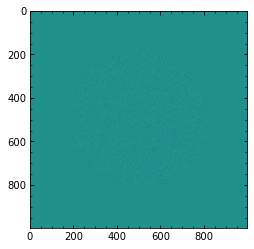

In [8]:
plt.imshow(np.real(WN_FT_fil))

In [9]:
# im1 = plt.imshow(WN)
# plt.show()
# im2 = plt.imshow(np.real(WN_FT))
# plt.show()
# im3 = plt.imshow(np.imag(WN_FT))
# plt.show()

# axial gain

In [46]:
f = screen['E'].copy() #in-phase illumination function
x = screen['X'][0] # x = y
B = 1. #scaling of the phase error
delta = B*np.real(WN_fil.copy()) #arbitrary phase error (real part)
sp_fd2 = interp.RectBivariateSpline(x,x,f*delta**2)
sp_fd = interp.RectBivariateSpline(x,x,f*delta)
sp_f = interp.RectBivariateSpline(x,x,f)
d_sq_bar = interp.RectBivariateSpline.integral(sp_fd2,0,10,0,10) / interp.RectBivariateSpline.integral(sp_f,0,10,0,10)
d_bar = interp.RectBivariateSpline.integral(sp_fd,0,10,0,10) / interp.RectBivariateSpline.integral(sp_f,0,10,0,10)
print(d_sq_bar,d_bar)
ratio_G_G0 = 1 - d_sq_bar + d_bar**2
print('Ratio of the axial gain to the no-error gain G/G0 is', ratio_G_G0)

0.9763913272740611 2.745629503781052e-06
Ratio of the axial gain to the no-error gain G/G0 is 0.023608672733477398


In [47]:
# G(theta, phi)?

In [48]:
def axial_gain(screen, k_in, k_out, amplitude):
    f = screen['E']
    x = screen['X'][0]
    WN_fil = filter_WN(screen, amplitude, k_in, k_out)
    delta = amplitude*np.real(WN_fil) #arbitrary phase error (real part)
    sp_fd2 = interp.RectBivariateSpline(x,x,f*delta**2)
    sp_fd = interp.RectBivariateSpline(x,x,f*delta)
    sp_f = interp.RectBivariateSpline(x,x,f)
    d_sq_bar = interp.RectBivariateSpline.integral(sp_fd2,0,10,0,10) / interp.RectBivariateSpline.integral(sp_f,0,10,0,10)
    d_bar = interp.RectBivariateSpline.integral(sp_fd,0,10,0,10) / interp.RectBivariateSpline.integral(sp_f,0,10,0,10)
    ratio_G_G0 = 1 - d_sq_bar + d_bar**2
    return(ratio_G_G0)

# building splines for WN?? 

In [49]:
#different k_in
kin = np.linspace(0,100,100)
kout = 150
ratio_in = []
for i in range(len(kin)):
    ratio_in.append(axial_gain(screen, kin[i], kout, 0.1))

#different k_out
kin = 5
kout = np.linspace(10,200,100)
ratio_out = []
for i in range(len(kout)):
    ratio_out.append(axial_gain(screen, kin, kout[i], 0.1))

#different amp
kin = 10
kout = 50
amp = np.linspace(0,1,100)
ratio_amp = []
for i in range(len(amp)):
    ratio_amp.append(axial_gain(screen, kin, kout, amp[i]))

#same annulus radius
radius = 20
kin = np.arange(0,100,5)
kout = kin+radius
amp = 0.1
ratio_r_20 = []
for i in range(len(kin)):
    ratio_r_20.append(axial_gain(screen, kin[i], kout[i], amp))

radius = 50
kin = np.arange(0,100,5)
kout = kin+radius
amp = 0.1
ratio_r_50 = []
for i in range(len(kin)):
    ratio_r_50.append(axial_gain(screen, kin[i], kout[i], amp))

In [51]:
#same annulus radius
radius = 10
kin = np.arange(0,100,5)
kout = kin+radius
amp = 0.1
ratio_r_10 = []
for i in range(len(kin)):
    ratio_r_10.append(axial_gain(screen, kin[i], kout[i], amp))

radius = 30
kin = np.arange(0,100,5)
kout = kin+radius
amp = 0.1
ratio_r_30 = []
for i in range(len(kin)):
    ratio_r_30.append(axial_gain(screen, kin[i], kout[i], amp))
    
radius = 40
kin = np.arange(0,100,5)
kout = kin+radius
amp = 0.1
ratio_r_40 = []
for i in range(len(kin)):
    ratio_r_40.append(axial_gain(screen, kin[i], kout[i], amp))

In [19]:
cl=mcp.gen_color(cmap="jet_r",n=5)
print(cl)

['#800000', '#ff9800', '#7aff7d', '#007dff', '#000080']


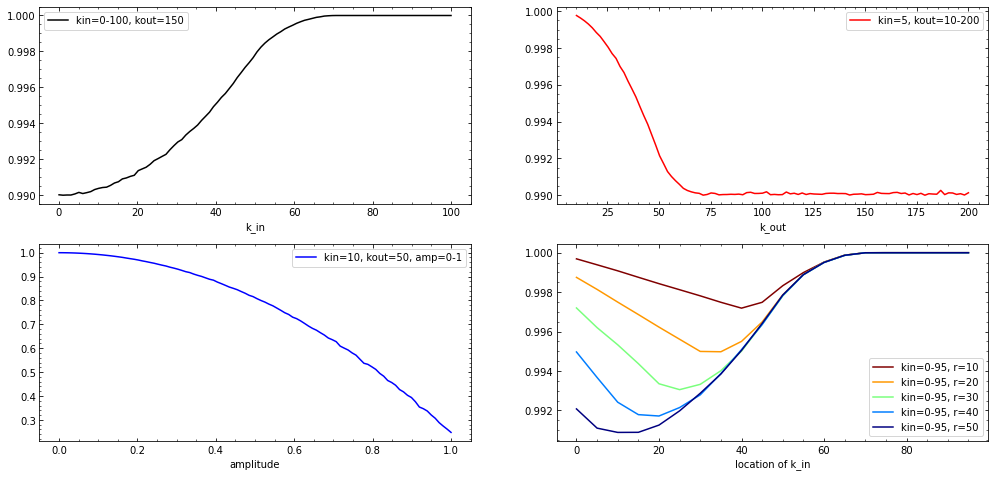

In [52]:
fig = plt.figure(figsize=(17,8))
ax1 = fig.add_subplot(221)
ax1.plot(np.linspace(0,100,100),ratio_in,color='black',label='kin=0-100, kout=150') #vary k_in
ax1.set_xlabel('k_in')
ax1.legend()
ax2 = fig.add_subplot(222)
ax2.plot(np.linspace(10,200,100),ratio_out, color='red',label='kin=5, kout=10-200') #vary k_out
ax2.set_xlabel('k_out')
ax2.legend()
ax3 = fig.add_subplot(223)
ax3.plot(np.linspace(0,1,100),ratio_amp, color='blue',label='kin=10, kout=50, amp=0-1') #vary amp
ax3.set_xlabel('amplitude')
ax3.legend()
ax4 = fig.add_subplot(224)
cl=mcp.gen_color(cmap="jet_r",n=5)
ax4.plot(np.arange(0,100,5),ratio_r_10,color=cl[0],label='kin=0-95, r=10')
ax4.plot(np.arange(0,100,5),ratio_r_20,color=cl[1],label='kin=0-95, r=20') #fix radius, vary annulus location
ax4.plot(np.arange(0,100,5),ratio_r_30,color=cl[2],label='kin=0-95, r=30')
ax4.plot(np.arange(0,100,5),ratio_r_40,color=cl[3],label='kin=0-95, r=40')
ax4.plot(np.arange(0,100,5),ratio_r_50,color=cl[4],label='kin=0-95, r=50')
ax4.set_xlabel('location of k_in')
ax4.legend()

In [66]:


N = 1000

# white noise
WN = np.random.normal(0,1,(N,N))
WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))

WN_ift = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT))) # filtered WN in real space

5.110192258345874


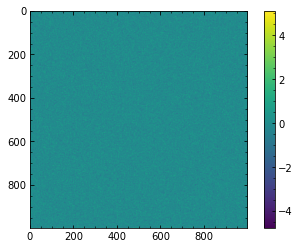

In [67]:
plt.imshow(WN)
plt.colorbar()
print(WN.max())

5.110192258345876

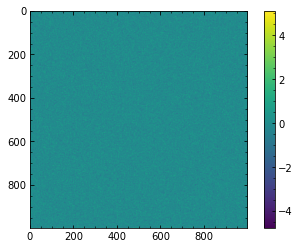

In [68]:
plt.imshow(np.real(WN_ift))
plt.colorbar()
np.real(WN_ift).max()

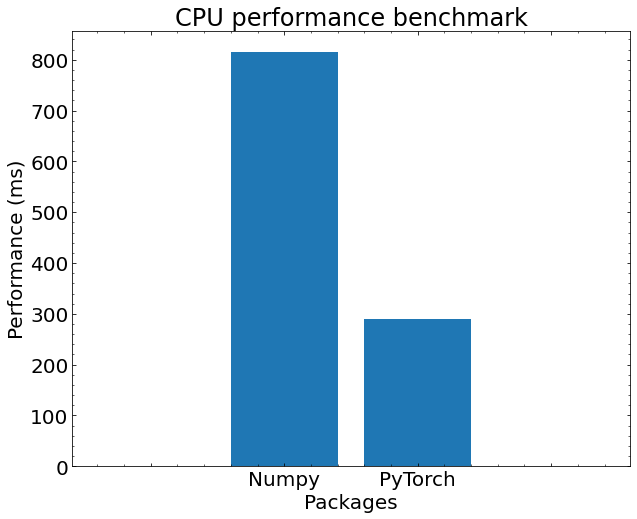

In [38]:
# benchmark
mpl.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [10, 8]
py = 815
tc = 290
x=['','Numpy','PyTorch',' ']
y = [0,py,tc,0]
plt.bar(x,y,width=0.8,align='center')
plt.xlabel('Packages')
plt.ylabel("Performance (ms)")
plt.title('CPU performance benchmark')
plt.show()

In [3]:
from pynufft import NUFFT

In [5]:
A = NUFFT()
om = np.random.randn(10,2)
Nd = (64,64)
Kd = (128,128)
Jd = (6,6)
print(A.plan(om, Nd, Kd, Jd))
x=np.random.randn(*Nd)
y = A.forward(x)

0


In [7]:
A.plan?

Signature: A.plan(*args, **kwargs)
Docstring:
Plan the NUFFT object with the geometry provided.

:param om: The M off-grid locates in the frequency domain,
            which is normalized between [-pi, pi]
:param Nd: The matrix size of the equispaced image.
           Example: Nd=(256,256) for a 2D image;
                     Nd = (128,128,128) for a 3D image
:param Kd: The matrix size of the oversampled frequency grid.
           Example: Kd=(512,512) for 2D image;
                    Kd = (256,256,256) for a 3D image
:param Jd: The interpolator size.
           Example: Jd=(6,6) for 2D image;
                    Jd = (6,6,6) for a 3D image
:param ft_axes: (Optional) The axes for Fourier transform.
                The default is all axes if 'None' is given.
:type om: numpy.float array, matrix size = M * ndims
:type Nd: tuple, ndims integer elements.
:type Kd: tuple, ndims integer elements.
:type Jd: tuple, ndims integer elements.
:type ft_axes: None, or tuple with optional integer ele